In [ ]:
# ✅ STEP 1: Mount Drive and Import Libraries
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q monai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.5 MB/s eta 0:00:00


In [ ]:
# ✅ STEP 1: Import Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from monai.networks.nets import resnet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ✅ STEP 3: Load .npz Data
data = np.load("/content/drive/MyDrive/vesselmnist3d_64.npz")
train_x, train_y = data['train_images'], data['train_labels']
val_x, val_y     = data['val_images'], data['val_labels']
test_x, test_y   = data['test_images'], data['test_labels']

In [ ]:
# ✅ STEP 4: Custom Dataset
def normalize(img):
    return img.astype(np.float32) / 255.0

class Vessel3DDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = normalize(self.images[idx])
        x = torch.tensor(x).unsqueeze(0)  # Add channel dim
        y = torch.tensor(self.labels[idx]).long()
        return x, y

train_set = Vessel3DDataset(train_x, train_y)
val_set   = Vessel3DDataset(val_x, val_y)
test_set  = Vessel3DDataset(test_x, test_y)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=16)
test_loader  = DataLoader(test_set, batch_size=16)


In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [ ]:
# ✅ STEP 5: Load ResNet3D-50
model = resnet.resnet50(spatial_dims=3, n_input_channels=1, num_classes=2).to(device)

In [ ]:
# ✅ STEP 6: Training Setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()


In [ ]:
def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device).view(-1)  # flatten label
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total


In [ ]:
# ✅ STEP 8: Training
print("🚀 Training...")
for epoch in range(10):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device).view(-1)  # ✅ Ensure y is 1D
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    val_acc = evaluate(val_loader)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Val Acc: {val_acc * 100:.2f}%")



🚀 Training...
Epoch 1 | Loss: 28.2069 | Val Acc: 90.05%
Epoch 2 | Loss: 23.0995 | Val Acc: 57.07%
Epoch 3 | Loss: 21.0602 | Val Acc: 88.48%
Epoch 4 | Loss: 19.2219 | Val Acc: 89.01%
Epoch 5 | Loss: 14.0087 | Val Acc: 91.62%
Epoch 6 | Loss: 12.0891 | Val Acc: 75.92%
Epoch 7 | Loss: 12.4143 | Val Acc: 89.53%
Epoch 8 | Loss: 7.0797 | Val Acc: 85.34%
Epoch 9 | Loss: 7.3349 | Val Acc: 79.06%
Epoch 10 | Loss: 8.3253 | Val Acc: 90.05%


In [ ]:
# ✅ STEP 9: Test Metrics
model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        prob = F.softmax(out, dim=1)
        pred = torch.argmax(prob, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
        y_prob.extend(prob[:, 1].cpu().numpy())

In [ ]:
# ✅ STEP 10: Classification Report & Confusion Matrix
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred))



📋 Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       339
           1       1.00      0.14      0.24        43

    accuracy                           0.90       382
   macro avg       0.95      0.57      0.60       382
weighted avg       0.91      0.90      0.87       382



🎯 ROC-AUC: 0.8487


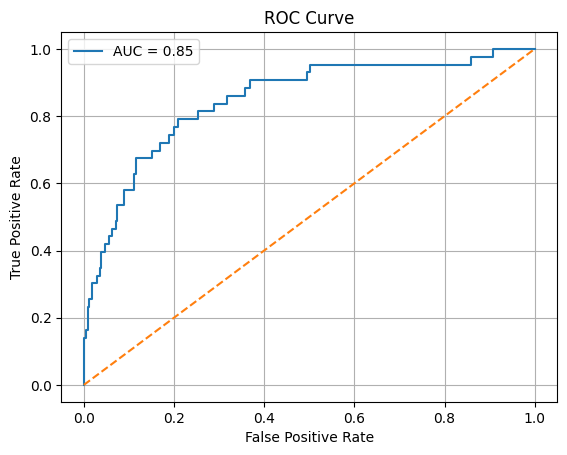

In [ ]:
# ✅ STEP 11: ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)
print(f"🎯 ROC-AUC: {auc:.4f}")

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


🧠 Random Sample Prediction:
Actual: 0 — Predicted: 0 — ✅ Correct ✅


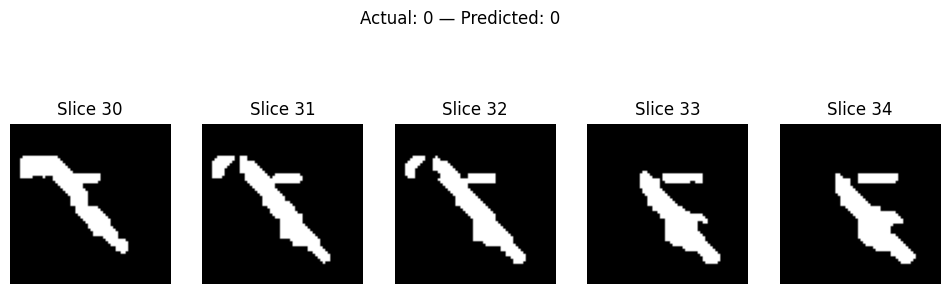

In [ ]:
# ✅ STEP 12: Random Sample Prediction + Visualization
idx = np.random.randint(len(test_set))
x, y = test_set[idx]  # x shape: (1, D, H, W)
x_display = x.squeeze(0).cpu().numpy()  # shape: (D, H, W)
x_input = x.unsqueeze(0).to(device)
y = y.item()

with torch.no_grad():
    out = model(x_input)
    pred = out.argmax(1).item()

print(f"\n🧠 Random Sample Prediction:")
print(f"Actual: {y} — Predicted: {pred} — {'✅ Correct ✅' if y == pred else '❌ Wrong ❌'}")

# ✅ Show center slices of the 3D image (axial view)
num_slices = x_display.shape[0]
center_slice = num_slices // 2

plt.figure(figsize=(12, 4))
for i, offset in enumerate([-2, -1, 0, 1, 2]):
    slice_idx = center_slice + offset
    if 0 <= slice_idx < num_slices:
        plt.subplot(1, 5, i + 1)
        plt.imshow(x_display[slice_idx], cmap='gray')
        plt.title(f"Slice {slice_idx}")
        plt.axis('off')

plt.suptitle(f"Actual: {y} — Predicted: {pred}")
plt.show()


In [ ]:
import plotly.express as px

fig = px.imshow(x_display,
                animation_frame=0,
                binary_string=True,
                color_continuous_scale='gray')
fig.update_layout(title="3D Image Slices",
                  coloraxis_showscale=False)
fig.show()
